In [1]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
import gensim
import nltk

In [2]:
seed = 5
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
path = r"D:\Uni\NLP\sst5"
data = pd.read_csv(os.path.join(path, "sst5.data.txt"))
print(data.shape)
data.head(10)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Uni\\NLP\\sst5/sst5.data.txt'

In [4]:
labels = pd.read_csv(os.path.join(path, "sst5.labels.txt"), header=None)
labels

,0,1
0,-2,very negative
1,-1,negative
2,0,neutral
3,1,positive
4,2,very positive


In [5]:
def get_seq_len(data):
    seq_len = []
    for s in data["text"]:
        tokens = nltk.word_tokenize(s)
        seq_len.append(len(tokens))
    return seq_len

def preprocess(text):
    text = text.lower()
    return text

def create_embedding_weights(wv, dictionary, embed_size=300):
    vocab_size = len(dictionary)
    weights = torch.empty((len(dictionary), embed_size))
    
    for key, idx in dictionary.token2id.items():
        if key == "<PAD>":
            weights[idx] = torch.zeros(embed_size)
        elif key == "<UNK>":
            weights[idx] = torch.empty(300).uniform_(-1, 1)
        else:
            try:
                weights[idx] = torch.from_numpy(wv[key].copy())
            except:
                weights[idx] = torch.empty(300).uniform_(-1, 1)
                        
    
    return weights

In [6]:
preprocessed_data = pd.DataFrame({"text": data["text"].apply(lambda x: preprocess(x)).values, 
                                  "label": data["label"].values+2})

preprocessed_data.head(10)

,text,label
0,reno himself can take credit for most of the m...,3
1,"despite the film 's shortcomings , the stories...",3
2,"despite its dry wit and compassion , the film ...",1
3,the central character is n't complex enough to...,2
4,rifkin no doubt fancies himself something of a...,0
5,"dodgy mixture of cutesy romance , dark satire ...",2
6,the only time 8 crazy nights comes close to hi...,2
7,... quite good at providing some good old fash...,3
8,"the huskies are beautiful , the border collie ...",3
9,there is so much plodding sensitivity .,2


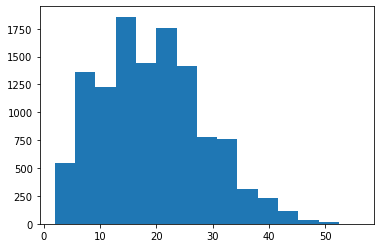

Max. tokens length 56
Min tokens length 2
Avg. tokens length 19.187436676798377


In [7]:
seq_lengthes = get_seq_len(preprocessed_data)
plt.hist(seq_lengthes, bins=15)
plt.show()

print(f"Max. tokens length {max(seq_lengthes)}")
print(f"Min tokens length {min(seq_lengthes)}")
print(f"Avg. tokens length {sum(seq_lengthes)/len(seq_lengthes)}")

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
train_x, test_x, train_y, test_y = train_test_split(preprocessed_data["text"], 
                                                    preprocessed_data["label"], 
                                                    train_size=0.80, 
                                                    random_state=seed)

In [10]:
print(f"Size of entire data: {len(preprocessed_data)}")
print(f"Size of training data: {len(train_x)}")
print(f"Size of the test data: {len(test_x)}")

Size of entire data: 11844
Size of training data: 9475
Size of the test data: 2369


In [11]:
train_tokens = [nltk.word_tokenize(x) for x in train_x]
train_tokens.insert(0, ["<PAD>", "<UNK>"])
dictionary = gensim.corpora.Dictionary(train_tokens)
len(dictionary)

17495

In [12]:
path_ = r"D:\Uni\NLP"
wv = gensim.models.KeyedVectors.load_word2vec_format(os.path.join(path_, "GoogleNews-vectors-negative300.bin"), 
                                                     binary=True)

In [13]:
weights = create_embedding_weights(wv, dictionary)

In [14]:
weights.size()

torch.Size([17495, 300])

In [15]:
class SST5Dataset(Dataset):
    def __init__(self, data, dictionary, seq_len):
        self.data = data
        self.dictionary = dictionary
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row["text"] 
        word_idx = []
        for i, w in enumerate(text.split()):
            if i < self.seq_len:
                try:
                    word_idx.append(self.word2idx(w))
                except:
                    word_idx.append(self.word2idx("<UNK>"))
                
                
        # padding the sequence     
        self.padding(word_idx)
        y = row["label"]
        x = torch.tensor(word_idx, dtype=torch.long)
        return x, y
    
    def word2idx(self, word):
        idx = dictionary.token2id[word]
        return idx
    
    def padding(self, list_):
        while len(list_) < self.seq_len:
            list_.append(self.word2idx("<PAD>"))

In [16]:
d = {"text": train_x, "label": train_y}
train_ = pd.DataFrame(d)

d = {"text": test_x, "label": test_y}
test_ = pd.DataFrame(d)

In [17]:
seq_len = 35
train_dataset = SST5Dataset(train_, dictionary, seq_len)
test_dataset = SST5Dataset(test_, dictionary, seq_len)

In [18]:
x, y = train_dataset[0]
x

tensor([ 6,  2,  7, 10,  4,  9,  8,  5,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [19]:
def accuracy(y_hat, y):
    _, index = torch.max(y_hat, 1)
    b = (index == y)
    res = torch.sum(b).float() / b.shape[0]
    return res.item()
    

@torch.enable_grad()    
def update(model, dataloader, criterion, opt, metric):
    device = next(model.parameters()).device
    model.train()
    err = []
    acc = []
    
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        err.append(loss.item())
        a = metric(y_hat, y)
        acc.append(a)
    return err, acc


@torch.no_grad()
def evaluate(model, dataloader, criterion, metric):
    device = next(model.parameters()).device
    model.eval()
    err = []
    acc = []
    
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        err.append(loss.item())
        a = metric(y_hat, y)
        acc.append(a)
    return err, acc


def mean(vals):
    return sum(vals) / len(vals)

def plot_results(train_acc, val_acc):
    plt.plot(list(range(len(train_acc))), train_acc, label="train acc.")
    plt.plot(list(range(len(val_acc))), val_acc, label="val. acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [20]:
class Network(nn.Module):

    def __init__(self, n_hidden, n_classes, weights, batch_size, seq_len, att_heads=4):
        super().__init__()
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.encoder = nn.Embedding.from_pretrained(weights)
        self.lstm = nn.LSTM(weights.size()[1], n_hidden, batch_first=True,
                            dropout=0.5, num_layers=2, bidirectional=True)
                            
        self.attention = nn.MultiheadAttention(n_hidden*2, att_heads, 0.5)
        self.decoder = nn.Linear(n_hidden*2, n_classes)
        self.dropout1 = nn.Dropout(p=0.5)        
        self.query = nn.Parameter(torch.Tensor(att_heads, batch_size, n_hidden*2))        
        nn.init.kaiming_uniform_(self.query)
        self.pad_idx = 0
            
            
    def forward(self, x):
        out, _ = self._forward(x)
        out = self.dropout1(out)
        logits = self.decoder(out[-1, :, :])
        return logits
    
    
    def get_attention_weights(self, x):
        _, w = self._forward(x)
        return w
    
    
    # helper function
    def _forward(self, x):
        mask = torch.zeros_like(x).bool()
        mask[torch.where(x==self.pad_idx)] = 1
        
        x = self.encoder(x)
        x = self.dropout1(x)
        out, (ht, ct) = self.lstm(x)  
    
        value = out.permute(1, 0, 2)
        key = out.permute(1, 0, 2)
        o, w = self.attention(self.query, key, value, key_padding_mask=mask)
        return o, w


In [21]:
batch_size = 16
lr = 0.001
n_epochs = 100
n_hidden = 128
n_classes = 5

weights = create_embedding_weights(wv, dictionary)
model = Network(n_hidden, n_classes, weights, batch_size, seq_len).to(device)
print(model)
criterion = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)
opt = optim.Adam(model.parameters(), lr=lr)

Network(
  (encoder): Embedding(17495, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): Linear(in_features=256, out_features=256, bias=True)
  )
  (decoder): Linear(in_features=256, out_features=5, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
)


In [22]:
train_acc_ = []
test_acc_ = []

# accuracy before first update
_, a = evaluate(model, train_dataloader, criterion, accuracy)
train_acc_.append(mean(a))
_, a = evaluate(model, test_dataloader, criterion, accuracy)
test_acc_.append(mean(a))

cnt = 0
for e in range(n_epochs):  
    _, train_acc = update(model, train_dataloader, criterion, opt, accuracy)
    _, test_acc = evaluate(model, test_dataloader, criterion, accuracy)
    
    if mean(test_acc) > max(test_acc_):
        # store model parameters
        state = {"state_dict": model.state_dict()}
        print(f"Model parameters stored at epoch {e} with validation acc. of {mean(test_acc)*100}%")
        # reset counter
        cnt = 0
    else:
        cnt += 1
        
    train_acc_.append(mean(train_acc))
    test_acc_.append(mean(test_acc))
    
    # early stopping
    if cnt > 10:
        print("Early stopping now. Model does not improve anymore.")
        break

Model parameters stored at epoch 0 with validation acc. of 42.1875%
Model parameters stored at epoch 2 with validation acc. of 43.91891891891892%
Model parameters stored at epoch 4 with validation acc. of 44.4679054054054%
Model parameters stored at epoch 5 with validation acc. of 44.84797297297297%
Model parameters stored at epoch 9 with validation acc. of 45.65033783783784%
Early stopping now. Model does not improve anymore.


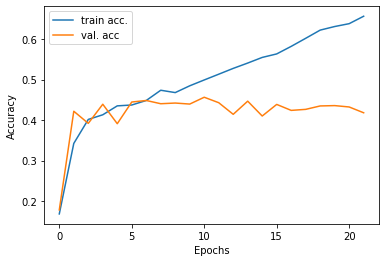

In [23]:
plot_results(train_acc_, test_acc_)